In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load the data

In [10]:
df_train_feature = pd.read_csv('../data.nosync/raw/train_features.csv')
df_train_target = pd.read_csv('../data.nosync/raw/train_salaries.csv')
df_test_feature = pd.read_csv('../data.nosync/raw/test_features.csv')

### Familiarize with data and sanity check it

Get to know about the data and make sure the type of the data in each column is matching the description and column name. 

In [11]:
num_train_samples, num_features = df_test_feature.shape
df_train = df_train_feature.merge(df_train_target, on='jobId')

print(f'There are {num_train_samples} train samples in training data with {num_features} features')
display(df_train_feature.info())
display(df_train_feature.head(3))

There are 1000000 train samples in training data with 8 features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


None

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38


In [82]:
df_train_target.info()
df_train_target.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137


### Check for missing info

check if what is the percentage of missing values (anything that is null, None, etc)

In [87]:
def replace_missing_data_with(df_list, missing_data_list=None, with_this=[None]):
    if missing_data_list is None or with_this is None:
        return
    
    if type(df_list) is not list:
        raise TypeError(f'df_list should be a pandas list. {type(df_list)} is not accepted here. ')
    
    for df in df_list:
        if type(df) is not pd.core.frame.DataFrame:
            raise TypeError(f'df_list should should contain only pandas pandas data-frame. list of {type(df)} is not accepted here. ')
    
    if type(missing_data_list) is not list:
        missing_data_list = list(missing_data_list)

    for df in df_list:
        df.replace(missing_data_list, with_this, inplace=False)

In [162]:
df_test_feature.replace(['NONE'], [None], inplace=True)
df_test_feature.head(10)
for col in df_test_feature:
    print(f"percentage of missing data in {col} column is equal to {100.0*df_test_feature[col].isnull().sum()/num_test_samples:0.2f}")

percentage of missing data in jobId column is equal to 0.00
percentage of missing data in companyId column is equal to 0.00
percentage of missing data in jobType column is equal to 0.00
percentage of missing data in degree column is equal to 0.00
percentage of missing data in major column is equal to 0.00
percentage of missing data in industry column is equal to 0.00
percentage of missing data in yearsExperience column is equal to 0.00
percentage of missing data in milesFromMetropolis column is equal to 0.00


In [163]:
df_train_feature.replace(['NONE'], [None], inplace=True)
df_train_feature.head(10)
for col in df_train_feature:
    print(f"percentage of missing train data in {col} column is equal to {100.0*df_train_feature[col].isnull().sum()/num_train_samples:0.2f}")

percentage of missing train data in jobId column is equal to 0.00
percentage of missing train data in companyId column is equal to 0.00
percentage of missing train data in jobType column is equal to 0.00
percentage of missing train data in degree column is equal to 0.00
percentage of missing train data in major column is equal to 0.00
percentage of missing train data in industry column is equal to 0.00
percentage of missing train data in yearsExperience column is equal to 0.00
percentage of missing train data in milesFromMetropolis column is equal to 0.00


This shows that a significant portion of "degree" and "major" is missing data and could potentially be dropped. But at the same time they are intuitively important features. 
For now we are going to keep them. So reverting back the None values to MISSING so that they get their own categroies. 

In [164]:
df_test_feature.replace([None], ['MISSING'], inplace=True)
df_train_feature.replace([None], ['MISSING'], inplace=True)

In [165]:
# sanity check there is no NaN, or None data
df_train.salary.isnull().any()

False

### Should we normalized numerical data for GD based optimizers?

In this part we wanna check what is the range of the diferent numerical variables. If they ar ein the same order, then we there is no need to normalized or standardize them. Otherwise, we need to take care of scaling them inot the same range

In [19]:
print(f"range of yearsExperience varable is {df_train_feature['yearsExperience'].max()-df_train_feature['yearsExperience'].min()}")
print(f"range of milesFromMetropolis varable is {df_train_feature['milesFromMetropolis'].max()-df_train_feature['milesFromMetropolis'].min()}")

range of yearsExperience varable is 24
range of milesFromMetropolis varable is 99


**There is no need for scaling**, based on this investigation. It should be noted that any new feature should fall into this range, as well, if we are going to use any GD based optimization model. 

### Summerize Categorical and Numerical features

Just get a hang of what is the statistics of both numerical and categorical values. 

In [166]:
df_train.describe(include = ['O'])

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684842137,COMP39,SENIOR,HIGH_SCHOOL,MISSING,WEB
freq,1,16193,125886,236976,532355,143206


jobId is unique and therefore does not carry any information. Hence, dropping it here onward. 

In [178]:
df_train.drop(columns='jobId', axis=1, inplace=True)

In [208]:
## get the list of categorical features
cat_feat_list = list(df_train.describe(include = ['O']).columns)
print(cat_feat_list)

['companyId', 'jobType', 'degree', 'major', 'industry']


Apart from ```degree``` and ```major``` features, all others seems to have a uniform distribution of data among difernet categories. 

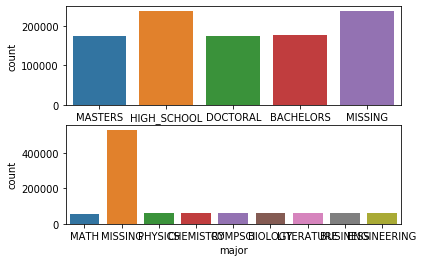

In [209]:
_, axes = plt.subplots(2, 1)
for i, feature in enumerate(['degree', 'major']):
    sns.countplot(x=feature, data=df_train, ax=axes[i])

In [210]:
df_train.describe(include = [np.number])

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [211]:
num_feat_list = df_train.describe(include = [np.number]).columns
print(num_feat_list)

Index(['yearsExperience', 'milesFromMetropolis', 'salary'], dtype='object')


### Visualize and probe salary

Hist plot all salaries and research it for potential feature eng efforts. Get rif of poterntial outliers. 

In [94]:
def get_iqr_bounds(df, feature, alpha = 1.5):
    
    if not isinstance(feature, str):
        raise TypeError('feature should be string, indicating the name of the feature')
    
    stats = df[feature].describe()
    iqr = stats['75%'] - stats['25%']
    lower, upper = stats['25%'] - alpha * iqr, stats['75%'] + alpha * iqr
    return lower, upper

In [96]:
salary_lower_bound, salary_upper_bound = get_iqr_bounds(df_train, 'salary')
df_train[df_train.salary < salary_lower_bound]
df_train[df_train.salary > salary_upper_bound]["jobType"].unique()

array(['CEO', 'CTO', 'VICE_PRESIDENT', 'CFO', 'JUNIOR', 'MANAGER',
       'SENIOR'], dtype=object)

In [98]:
df_train.jobType.unique()

array(['CFO', 'CEO', 'VICE_PRESIDENT', 'MANAGER', 'JUNIOR', 'JANITOR',
       'CTO', 'SENIOR'], dtype=object)

In [116]:
df_train[(df_train.salary > salary_upper_bound) & (df_train.jobLevel == 'MANAGER')]

,jobId,companyId,jobLevel,degree,major,industry,yearsExperience,milesFromMetropolis,salary
10508,JOB1362684418195,COMP23,MANAGER,BACHELORS,BUSINESS,FINANCE,23,1,229
26851,JOB1362684434538,COMP44,MANAGER,DOCTORAL,ENGINEERING,OIL,24,12,253
40613,JOB1362684448300,COMP22,MANAGER,DOCTORAL,MATH,FINANCE,24,6,251
46275,JOB1362684453962,COMP27,MANAGER,MASTERS,ENGINEERING,OIL,22,24,223
53319,JOB1362684461006,COMP22,MANAGER,DOCTORAL,ENGINEERING,WEB,23,9,221
...,...,...,...,...,...,...,...,...,...
984697,JOB1362685392384,COMP23,MANAGER,BACHELORS,BUSINESS,FINANCE,17,0,231
985043,JOB1362685392730,COMP54,MANAGER,DOCTORAL,BUSINESS,OIL,24,27,221
985255,JOB1362685392942,COMP5,MANAGER,MASTERS,COMPSCI,FINANCE,24,22,225
994039,JOB1362685401726,COMP8,MANAGER,MASTERS,BIOLOGY,OIL,24,1,226


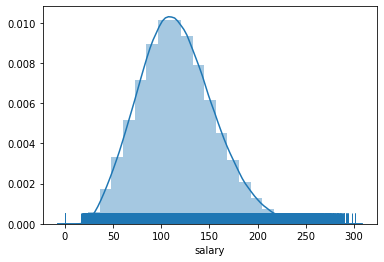

In [122]:
sns.distplot(df_train.salary, bins=25, rug=True)

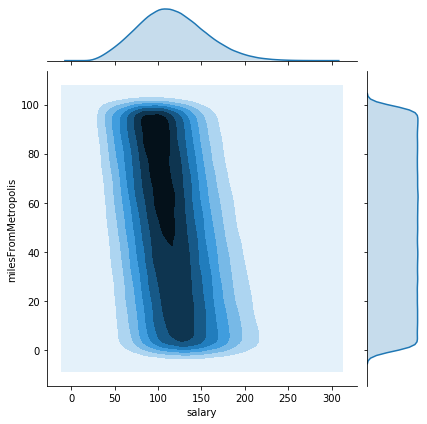

In [125]:
sns.jointplot(data=df_train, x="salary", y="milesFromMetropolis", kind="kde")

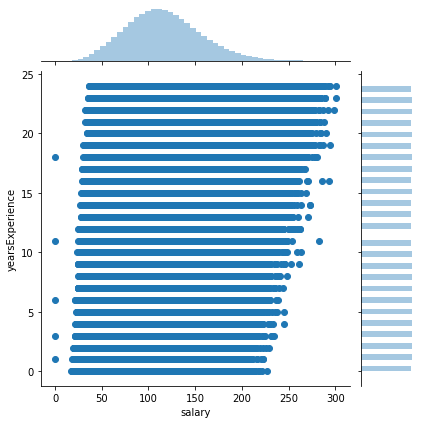

In [127]:
sns.jointplot(data=df_train, x="salary", y="yearsExperience")

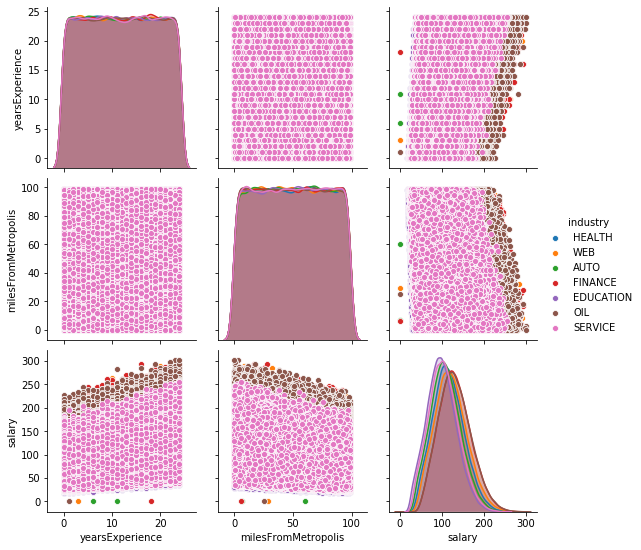

In [128]:
sns.pairplot(df_train, hue="industry")

from these plots and investigation, looks like we have lower bound outliers, so we'll get rid of them.

In [132]:
df_train = df_train[df_train.salary > salary_lower_bound]
df_train.shape

(999995, 9)

**look into categorical features**

try to see if there is any correlation between any of the categories and the target variable.

In [141]:
df_train.groupby("degree")["salary"].describe()

,count,mean,std,min,25%,50%,75%,max
degree,,,,,,,,
BACHELORS,175495.0,125.454663,35.042720,35.0,100.0,122.0,148.0,294.0
DOCTORAL,175362.0,135.490979,35.790555,45.0,109.0,132.0,158.0,301.0
HIGH_SCHOOL,236975.0,101.921085,36.112684,18.0,75.0,99.0,125.0,260.0
MASTERS,175310.0,130.505647,35.399830,38.0,105.0,127.0,153.0,301.0


In [153]:
df_train.groupby("degree")["salary"].mean().sort_values()

degree
HIGH_SCHOOL    101.921085
BACHELORS      125.454663
MASTERS        130.505647
DOCTORAL       135.490979
Name: salary, dtype: float64

In [220]:
df_train["degree"].unique()

array(['MASTERS', 'HIGH_SCHOOL', 'DOCTORAL', 'BACHELORS', None],
      dtype=object)

In [224]:
df_train.groupby(["degree", "major"])["salary"].mean().sort_values()

degree     major      
BACHELORS  LITERATURE     119.335256
           BIOLOGY        123.204343
           CHEMISTRY      123.906966
MASTERS    LITERATURE     124.215313
BACHELORS  PHYSICS        125.209302
           COMPSCI        126.965316
MASTERS    BIOLOGY        127.744510
BACHELORS  MATH           128.211868
MASTERS    CHEMISTRY      129.095825
DOCTORAL   LITERATURE     129.674594
MASTERS    PHYSICS        130.622320
BACHELORS  BUSINESS       130.890071
MASTERS    COMPSCI        132.436852
DOCTORAL   BIOLOGY        132.900799
MASTERS    MATH           133.334637
BACHELORS  ENGINEERING    133.522468
DOCTORAL   CHEMISTRY      134.241379
           PHYSICS        135.252974
MASTERS    BUSINESS       135.809151
DOCTORAL   COMPSCI        136.887929
MASTERS    ENGINEERING    138.186407
DOCTORAL   MATH           138.394916
           BUSINESS       140.227459
           ENGINEERING    143.678077
Name: salary, dtype: float64

from this, it is apparent that if we treat degree as an ordinal value, there is a high correlation between degree and salary. will consider this as an ordinal value, with HIGH_SCHOOL being the lowest and DOCTORAL being the highest.

In [150]:
df_train.groupby("major")["salary"].mean().sort_values()

major
LITERATURE     124.423097
BIOLOGY        127.932664
CHEMISTRY      129.072085
PHYSICS        130.372436
COMPSCI        132.075605
MATH           133.322042
BUSINESS       135.648980
ENGINEERING    138.441342
Name: salary, dtype: float64

In [54]:
df_train.groupby("industry")["salary"].mean().sort_values()

industry
EDUCATION     99.448386
SERVICE      104.446820
AUTO         109.433690
HEALTH       115.735540
WEB          121.644512
FINANCE      130.746743
OIL          130.952946
Name: salary, dtype: float64

In [158]:
def seperate_features_into_categorical_numerical_time(df):
    '''returns three seperate dataframes. the first one is the categorical portion and the second one is the numerical part and third one is timeData portion of the data'''
    return df.select_dtypes(include=['category', 'object']), df.select_dtypes(include='number'), df.select_dtypes(include=['datetime', 'datetime64', 'timedelta64', 'timedelta'])


In [161]:
df_train_cat_feat, df_train_num_feat, _ = seperate_features_into_categorical_numerical_time(df_train)

**Correlation between features**

look into the correlation between all pairs of features. adding new ordinal features for features "degree, industry, and major" based on above mappings, to investigate any correlation between these features. 

In [146]:
def encode_ordinal(df, features_list, target, replace=False, verbose=False):
    
    for feature in features_list:
        
        if feature not in df.columns:
            print(f"{feature} is not among the feature. skipping ... ")
            continue
        
        map_series = df.groupby(feature)[target].mean().sort_values()
        
        if verbose:
            print(map_series)
        
        map_dict = map_series.to_dict();
        
        if replace:
            df[feature] = df[feature].replace(map_dict)
        else:
            df[feature + "_ordinal"] = df[feature].replace(map_dict)
    
    return df

In [66]:
df_train_new = encode_ordinal(df_train, ["industry", "degree", "major"], "salary")

In [67]:
df_train_new[['industry_ordinal', 'salary']].head()

,industry_ordinal,salary
0,115.735540,130
1,121.644512,101
2,115.735540,137
3,109.433690,142
4,130.746743,163


In [174]:
df_train_new.corr()

,yearsExperience,milesFromMetropolis,salary,industry_ordinal,degree_ordinal,major_ordinal
yearsExperience,1.000000,0.000672,0.375013,0.000709,-0.000052,-0.000161
milesFromMetropolis,0.000672,1.000000,-0.297686,-0.001102,0.001994,-0.000577
salary,0.375013,-0.297686,1.000000,0.296626,0.357662,0.116771
industry_ordinal,0.000709,-0.001102,0.296626,1.000000,0.000307,-0.001813
degree_ordinal,-0.000052,0.001994,0.357662,0.000307,1.000000,-0.001062
major_ordinal,-0.000161,-0.000577,0.116771,-0.001813,-0.001062,1.000000


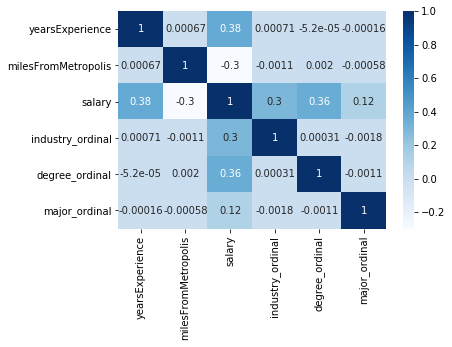

In [181]:

sns.heatmap(df_train_new.corr(), cmap='Blues', annot=True)

There doesn't seem to be any significant correlation between features. 

### Base-Line model for feature importance

In this section we will build two simple models using RandomForest and XGBoost, in order to identify the most important features. This info can be used to create new categorical features based on the combination of these important features. Hopefully, these features will improve the results of SVM, Linear Regression, and KNN meahtods, as these methods are not capable of capturing the relationship between features. 

It should be noted that sklearn.ensemble.RandomForestRegressor internally will convert all data into np.float32. That means that all the categorical features should be encodede into numerical flaot features. 

Usually the best way of encoding categorical features is  1-hot-encoding which does not assume any relation between different categories. One down side of this method is that it will result in highly sparse matrix after encoding especially when the categorical feature is of high cardinality. In our case, one of the seeminglt important vategorical feature, companyId, is hight cardinal and will suffer from this drawback. Also since this is just a baseline method, and in general DT based methods can handle categorical features by nature at this point we will just Ordinally encode the categorical features. 

Ordinal encoding, suggests that there is hierarchical relation between different categories. Since we are predicting salary, it seems to be fair to assume that the order of categories in each feature is proportional to the mean of salary for that category. In other words, we will be using ```encode_ordinal()``` method introduced above to take care of tis encoding. 

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [152]:
## Some minor clean-up, enconding and the train/test split

# first get rid of unique feature as it doesn't carry any info - jobId
try:
    df_train.drop(['jobId'], axis=1, inplace=True)
except KeyError as kr:
    print(KeyError)

# ordinal encoding of categorical features
df_train_encoded = encode_ordinal(df_train, cat_feat_list, 'salary', replace=True, verbose=False)

# some more clean-up 
X_target  = df_train_encoded['salary']
X_feature = df_train_encoded.drop(['salary'], axis=1)

display(X_feature.head(3))

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_feature, X_target, test_size=0.20)

<class 'KeyError'>
jobId is not among the feature. skipping ... 


,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,115.345049,135.458547,130.504903,133.319735,115.735540,10,83
1,115.756548,145.311425,101.920654,102.583479,121.644512,3,73
2,116.224249,125.367629,135.489433,130.372436,115.735540,10,38


In [155]:
# fit a baseline random forest to extract the important features
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=4, random_state=13)
rf_model.fit(X_train, y_train)
# print(rf_model.feature_importances_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                      oob_score=False, random_state=13, verbose=0,
                      warm_start=False)

In [160]:
# print the feature importance
display(dict(zip(X_train.columns, rf_model.feature_importances_)))

{'companyId': 0.0,
 'jobType': 0.4650713815439221,
 'degree': 0.15089290985066667,
 'major': 0.0010681014625044582,
 'industry': 0.11133829665801025,
 'yearsExperience': 0.1730207318084255,
 'milesFromMetropolis': 0.09860857867647109}

**NOTE** We will use the result of this method in order generate new features. First thing in mind is that we can generate new categorical features based on combination of top 2~4 features. 

In [172]:
## PCA models?

#### PlayGround - PlayGround - PlayGround - PlayGround

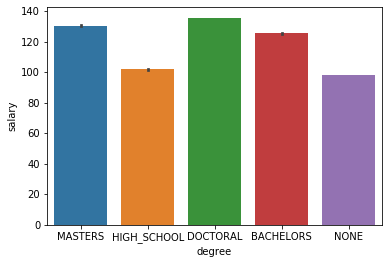

In [14]:
for col in ['degree']:
    ax = sns.barplot(x=col, y='salary', data=df_train)

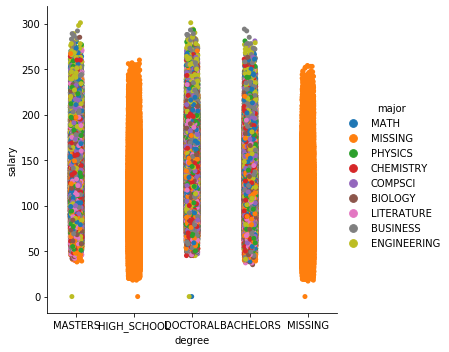

In [174]:
sns.catplot(x='degree', y='salary', hue='major', data=df_train)

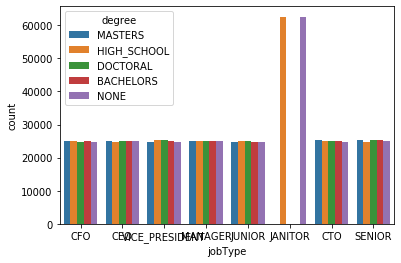

In [29]:
## looks like we have a candidate for categorical cobinations
0, 1, 2
sns.countplot(x='jobType', data=df_train, hue='degree')